In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import warnings
import gc
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# Ruta al archivo Excel
file_path = '/Users/sarahmendoza/Documents/Maestria/Proyecto integrador/renta_CDMX_2024.csv'

# Leer el archivo 
df = pd.read_csv(file_path)

# Mostrar las primeras filas
df.head()

/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_76864/2753759782.py:5: DtypeWarning: Columns (0,2,11,13,15,17,21,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,direccion,id_tipo_propiedad,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,...,id_cve_geo_col,Colonia,precio_oferta,fecha_oferta,precio_m2,cp,superficie_terreno,amenidades,elevador,ubicacion
0,NaN,4.0,Departamento,74.0,3.0,2.0,5.0,1.0,19.464082,-99.120232,...,9005245.0,Guadalupe Tepeyac,16000.0,15/04/2024,216.216216,7840.0,74.0,NaN,NaN,POINT (-99.1202321 19.4640821)
1,NaN,4.0,Departamento,200.0,3.0,3.0,7.0,3.0,19.382607,-99.161064,...,90142394.0,Del Valle Centro,55000.0,21/02/2024,275.000000,3100.0,200.0,NaN,NaN,POINT (-99.1610642 19.3826071)
2,"Miguel Bernard, Col. La Escalera C.P. 07320, G...",4.0,Departamento,74.0,3.0,1.0,0.0,NaN,19.508087,-99.136730,...,9005217.0,Sierravista,11000.0,19/03/2024,148.648649,7320.0,NaN,"""{'amenidades': {'cocina_amueblada': None, 'pi...",0.0,POINT (-99.1367299 19.5080874)
3,"Norte 79 B 224 A - 1, Col. Un Hogar Para Cada ...",4.0,Departamento,45.0,1.0,1.0,0.0,NaN,19.475753,-99.175971,...,900221.0,Un Hogar Para Cada Trabajador,7600.0,21/03/2024,168.888889,2060.0,NaN,"""{'amenidades': {'cocina_amueblada': None, 'pi...",0.0,POINT (-99.1759713 19.4757532)
4,"SN, Col. Romero Rubio C.P. 15400, Venustiano C...",4.0,Departamento,65.0,2.0,1.0,0.0,NaN,19.442391,-99.096380,...,9017280.0,Romero Rubio,11000.0,16/03/2024,169.230769,15400.0,NaN,"""{'amenidades': {'cocina_amueblada': None, 'pi...",0.0,POINT (-99.09638 19.442391)


In [3]:
print(df.columns)

Index(['direccion', 'id_tipo_propiedad', 'tipo_propiedad', 'area_construida',
       'recamaras', 'banos', 'edad', 'estacionamientos', 'latitud', 'longitud',
       'id_cve_geo_edo', 'Estado', 'id_cve_geo_muni', 'Minicipio',
       'id_cve_geo_col', 'Colonia', 'precio_oferta', 'fecha_oferta',
       'precio_m2', 'cp', 'superficie_terreno', 'amenidades', 'elevador',
       'ubicacion'],
      dtype='object')


In [4]:
df.columns = df.columns.str.strip() # Eliminar espacios al principio y al final de los nombres de columnas

# Eliminar columnas no deseadas
columnas_eliminar = [
    'direccion', 'id_tipo_propiedad', 'id_cve_geo_muni',
    'id_cve_geo_col', 'superficie_terreno', 'amenidades',
    'elevador', 'ubicacion'
]

df_clean = df.drop(columns=columnas_eliminar)

# Reordenar columnas 
nuevo_orden = [
    'tipo_propiedad', 'area_construida', 'recamaras', 'banos',
    'edad', 'estacionamientos', 'latitud', 'longitud', 'Municipio',
    'Colonia', 'precio_oferta', 'fecha_oferta', 'precio_m2', 'cp'
]

df_clean = df_clean.rename(columns={'Minicipio': 'Municipio'}) 

df_clean = df_clean[nuevo_orden]

In [5]:
df_clean.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,Colonia,precio_oferta,fecha_oferta,precio_m2,cp
0,Departamento,74.0,3.0,2.0,5.0,1.0,19.464082,-99.120232,Gustavo A. Madero,Guadalupe Tepeyac,16000.0,15/04/2024,216.216216,7840.0
1,Departamento,200.0,3.0,3.0,7.0,3.0,19.382607,-99.161064,Benito Juárez,Del Valle Centro,55000.0,21/02/2024,275.000000,3100.0
2,Departamento,74.0,3.0,1.0,0.0,NaN,19.508087,-99.136730,Gustavo A. Madero,Sierravista,11000.0,19/03/2024,148.648649,7320.0
3,Departamento,45.0,1.0,1.0,0.0,NaN,19.475753,-99.175971,Azcapotzalco,Un Hogar Para Cada Trabajador,7600.0,21/03/2024,168.888889,2060.0
4,Departamento,65.0,2.0,1.0,0.0,NaN,19.442391,-99.096380,Venustiano Carranza,Romero Rubio,11000.0,16/03/2024,169.230769,15400.0


Análisis Exploratorio de Datos (EDA):

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753652 entries, 0 to 753651
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tipo_propiedad    124516 non-null  object 
 1   area_construida   124516 non-null  float64
 2   recamaras         118743 non-null  float64
 3   banos             115639 non-null  float64
 4   edad              109180 non-null  float64
 5   estacionamientos  75941 non-null   float64
 6   latitud           124516 non-null  float64
 7   longitud          124516 non-null  float64
 8   Municipio         124516 non-null  object 
 9   Colonia           123469 non-null  object 
 10  precio_oferta     124516 non-null  float64
 11  fecha_oferta      124516 non-null  object 
 12  precio_m2         124516 non-null  float64
 13  cp                124515 non-null  float64
dtypes: float64(10), object(4)
memory usage: 80.5+ MB


In [7]:
df_CDMX = df_clean.dropna(subset=['recamaras', 'banos']) #Eliminar filas si un conjunto específico de columnas tiene nulos

In [8]:
df_CDMX.fillna(0, inplace=True)  # Reemplaza todos los nulos con 0

/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_76864/3148866280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CDMX.fillna(0, inplace=True)  # Reemplaza todos los nulos con 0


In [9]:
#Convertir una columna de tipo object a category para ahorrar memoria o mejorar el rendimiento en operaciones analíticas


columnas_a_convertir = ['Municipio', 'Colonia', 'cp','tipo_propiedad']
for col in columnas_a_convertir:
    df_CDMX[col] = df_CDMX[col].astype('category')

/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_76864/2184837273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CDMX[col] = df_CDMX[col].astype('category')
/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_76864/2184837273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CDMX[col] = df_CDMX[col].astype('category')
/var/folders/ns/82j_1hfj7f188gzxpzd27zfh0000gn/T/ipykernel_76864/2184837273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [10]:
df_CDMX = df_CDMX.copy()
df_CDMX['fecha_oferta'] = pd.to_datetime(df_CDMX['fecha_oferta'], dayfirst=True)

In [11]:
# Lista de las columnas a convertir
columnas_a_convertir = ['recamaras', 'banos', 'edad','estacionamientos']

# Convertir las columnas especificadas a enteros
df_CDMX[columnas_a_convertir] = df_CDMX[columnas_a_convertir].astype('int64')

In [12]:
# Convertir una columna de tipo object a float
#df_CDMX['precio_oferta'] = pd.to_numeric(df_CDMX['precio_oferta'], errors='coerce')

In [13]:
df_CDMX.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113835 entries, 0 to 124515
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   tipo_propiedad    113835 non-null  category      
 1   area_construida   113835 non-null  float64       
 2   recamaras         113835 non-null  int64         
 3   banos             113835 non-null  int64         
 4   edad              113835 non-null  int64         
 5   estacionamientos  113835 non-null  int64         
 6   latitud           113835 non-null  float64       
 7   longitud          113835 non-null  float64       
 8   Municipio         113835 non-null  category      
 9   Colonia           113835 non-null  category      
 10  precio_oferta     113835 non-null  float64       
 11  fecha_oferta      113835 non-null  datetime64[ns]
 12  precio_m2         113835 non-null  float64       
 13  cp                113835 non-null  category      
dtypes: catego

In [14]:
df_CDMX.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,Colonia,precio_oferta,fecha_oferta,precio_m2,cp
0,Departamento,74.0,3,2,5,1,19.464082,-99.120232,Gustavo A. Madero,Guadalupe Tepeyac,16000.0,2024-04-15,216.216216,7840.0
1,Departamento,200.0,3,3,7,3,19.382607,-99.161064,Benito Juárez,Del Valle Centro,55000.0,2024-02-21,275.000000,3100.0
2,Departamento,74.0,3,1,0,0,19.508087,-99.136730,Gustavo A. Madero,Sierravista,11000.0,2024-03-19,148.648649,7320.0
3,Departamento,45.0,1,1,0,0,19.475753,-99.175971,Azcapotzalco,Un Hogar Para Cada Trabajador,7600.0,2024-03-21,168.888889,2060.0
4,Departamento,65.0,2,1,0,0,19.442391,-99.096380,Venustiano Carranza,Romero Rubio,11000.0,2024-03-16,169.230769,15400.0


In [15]:
print(df_CDMX.describe())

       area_construida      recamaras          banos           edad  \
count    113835.000000  113835.000000  113835.000000  113835.000000   
mean        165.975229       2.366891       2.103167       7.364870   
min          10.000000       0.000000       0.000000       0.000000   
25%          80.000000       2.000000       2.000000       0.000000   
50%         115.000000       2.000000       2.000000       1.000000   
75%         200.000000       3.000000       3.000000      10.000000   
max        4994.000000      10.000000      10.000000     100.000000   
std         153.221633       0.868559       0.900707      11.581167   

       estacionamientos        latitud       longitud  precio_oferta  \
count     113835.000000  113835.000000  113835.000000  113835.000000   
mean           1.176044      19.396067     -99.192459   41606.136024   
min            0.000000      19.179771     -99.346499    2000.000000   
25%            0.000000      19.363910     -99.211934   20000.000000   


Variables Categóricas

In [16]:
# Frecuencias para todas las columnas categóricas

categorical_columns = ['tipo_propiedad', 'Municipio', 'Colonia', 'cp']
frecuencias = {}
for col in categorical_columns:
    frecuencias[col] = df_CDMX[col].value_counts()

# Mostrar resultados
for col, freq in frecuencias.items():
    print(f"Frecuencias para {col}:\n{freq}\n")

Frecuencias para tipo_propiedad:
tipo_propiedad
Departamento    97961
Casa            15874
Name: count, dtype: int64

Frecuencias para Municipio:
Municipio
Miguel Hidalgo            34704
Cuauhtémoc                20166
Benito Juárez             15345
Cuajimalpa de Morelos     13663
Álvaro Obregón            11760
Coyoacán                   4340
Tlalpan                    4253
Azcapotzalco               2125
Gustavo A. Madero          1861
La Magdalena Contreras     1420
Iztapalapa                 1220
Venustiano Carranza        1065
Iztacalco                   961
Xochimilco                  722
Tláhuac                     182
Milpa Alta                   48
Name: count, dtype: int64

Frecuencias para Colonia:
Colonia
Polanco                 14610
Granada                  6502
Roma Norte               4469
Lomas De Chapultepec     3345
Cuauhtemoc               2977
                        ...  
Tlacoyaque                  1
Belen De Las Flores         1
Tlalmille                   1


Variables numéricas

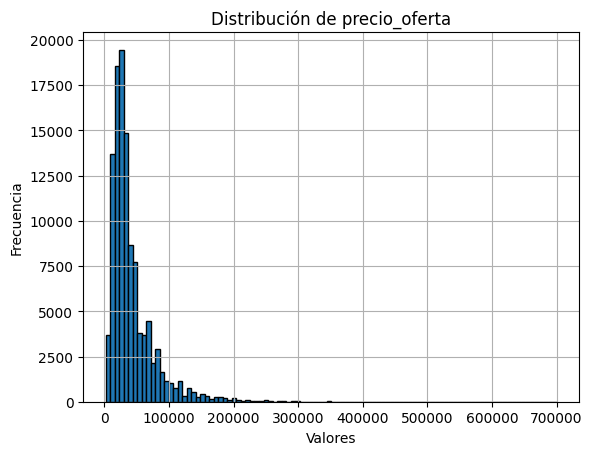

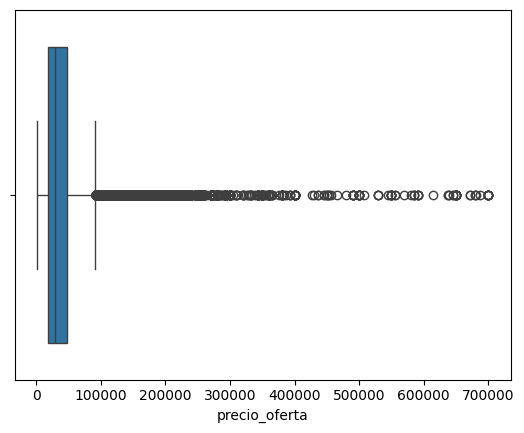

In [17]:
# Histograma
df_CDMX['precio_oferta'].hist(bins=100, edgecolor='black')
plt.title('Distribución de precio_oferta')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot para detectar outliers
sns.boxplot(x=df['precio_oferta'])
plt.show()

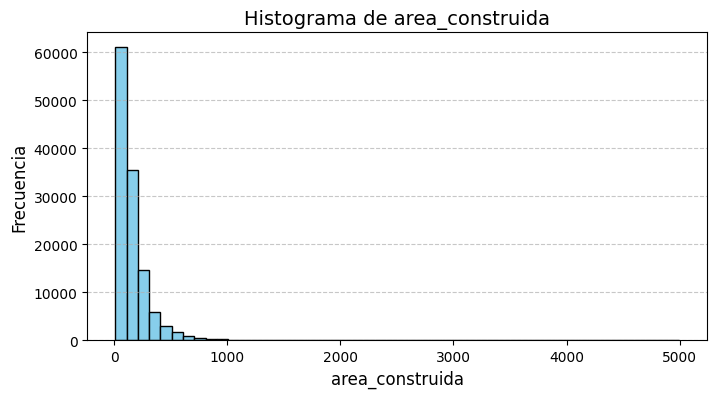

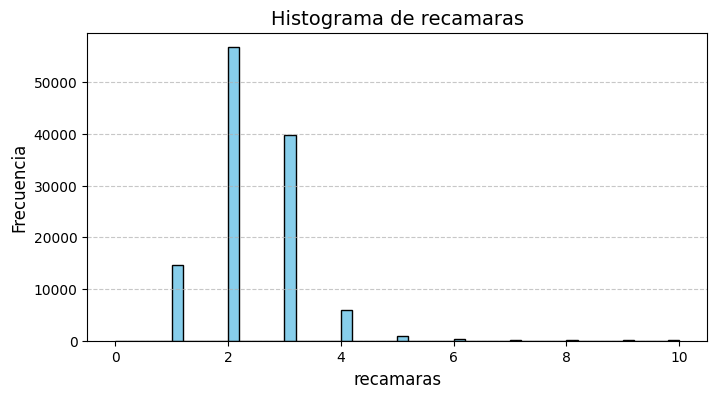

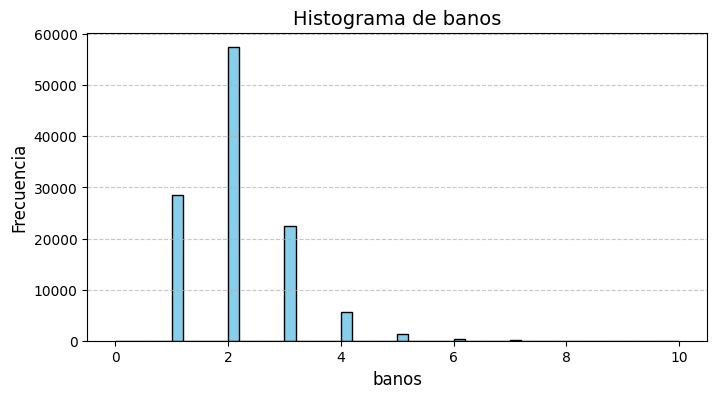

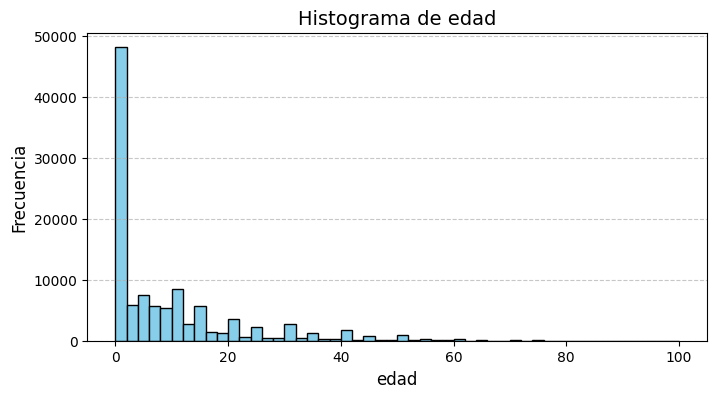

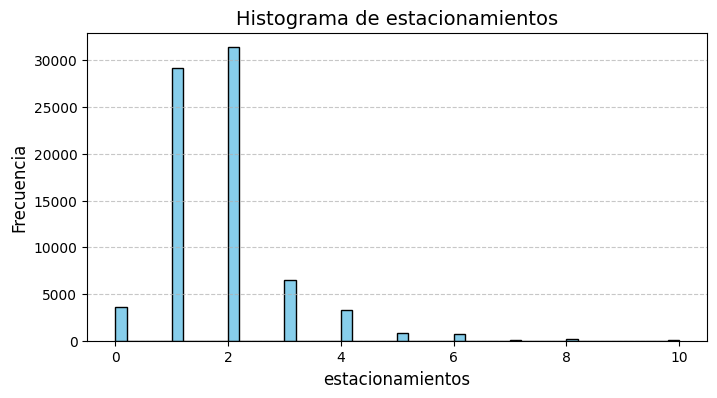

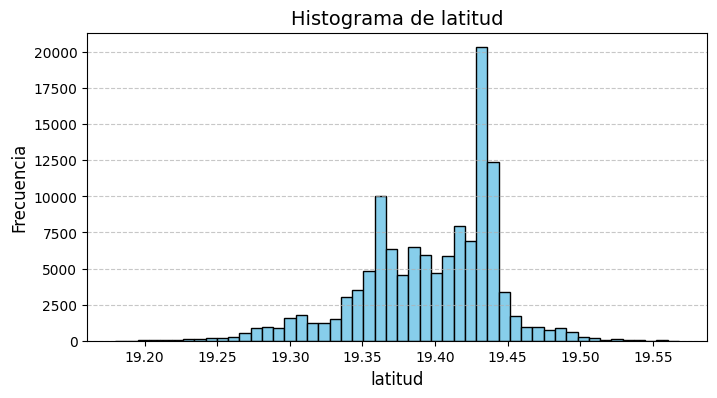

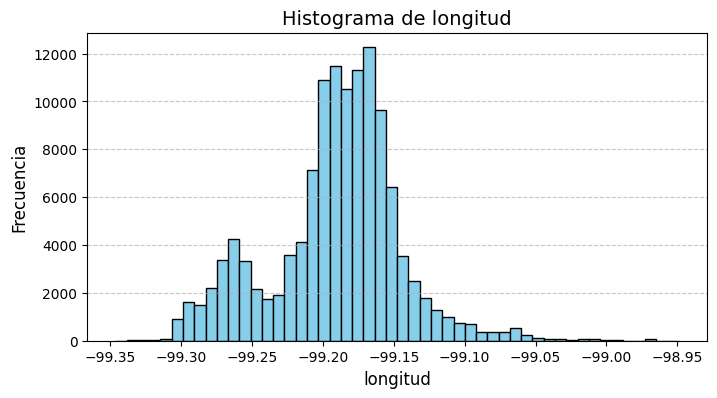

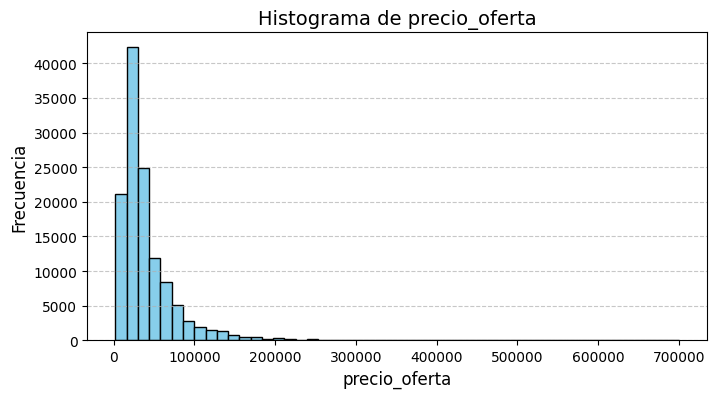

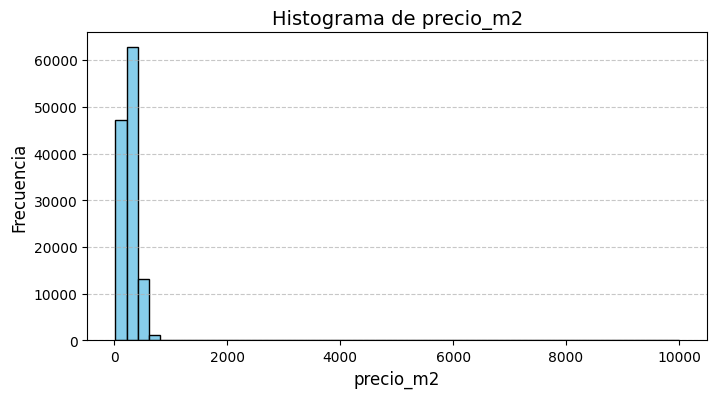

In [18]:
# Identificar todas las columnas numéricas
numerical_columns = df_CDMX.select_dtypes(include=['float64', 'int64']).columns

# Generar histogramas para cada columna numérica
for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df[col], bins=50, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [19]:
# Detectar outliers con IQR
Q1 = df_CDMX['precio_oferta'].quantile(0.25)
Q3 = df_CDMX['precio_oferta'].quantile(0.75)
IQR = Q3 - Q1

# Filtrar outliers
outliers = df_CDMX[(df_CDMX['precio_oferta'] < Q1 - 1.5 * IQR) | (df_CDMX['precio_oferta'] > Q3 + 1.5 * IQR)]
print(outliers)

       tipo_propiedad  area_construida  recamaras  banos  edad  \
11       Departamento            350.0          3      3     0   
17               Casa            587.0          6      0     0   
168              Casa            428.1          4      5     5   
211      Departamento            400.0          4      4    22   
223      Departamento            350.0          3      3     1   
...               ...              ...        ...    ...   ...   
124347   Departamento            400.0          4      4     2   
124371   Departamento            500.0          3      3     5   
124376   Departamento            340.0          4      2    10   
124386   Departamento            220.0          3      3     4   
124439   Departamento            290.0          3      3    15   

        estacionamientos    latitud   longitud              Municipio  \
11                     4  19.427831 -99.221820         Miguel Hidalgo   
17                     6  19.434535 -99.201117         Miguel

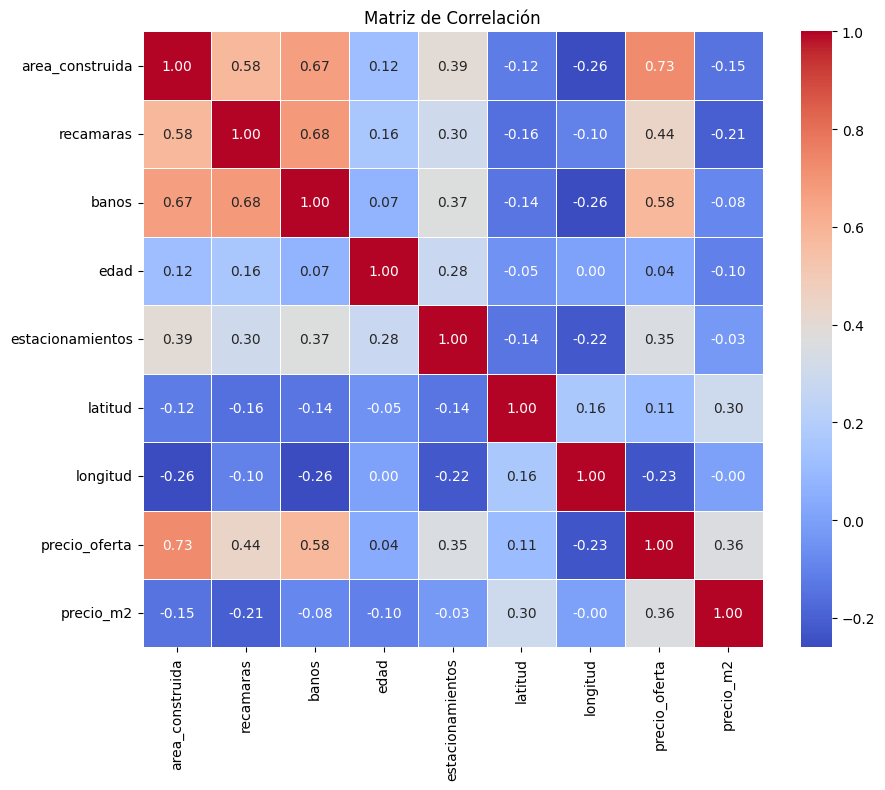

In [20]:
# Seleccionar solo las columnas numéricas
df_numeric = df_CDMX.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [21]:
df_CDMX_sin_fecha = df_CDMX.drop(columns=['fecha_oferta'])

In [22]:
df_CDMX_sin_fecha.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,Colonia,precio_oferta,precio_m2,cp
0,Departamento,74.0,3,2,5,1,19.464082,-99.120232,Gustavo A. Madero,Guadalupe Tepeyac,16000.0,216.216216,7840.0
1,Departamento,200.0,3,3,7,3,19.382607,-99.161064,Benito Juárez,Del Valle Centro,55000.0,275.000000,3100.0
2,Departamento,74.0,3,1,0,0,19.508087,-99.136730,Gustavo A. Madero,Sierravista,11000.0,148.648649,7320.0
3,Departamento,45.0,1,1,0,0,19.475753,-99.175971,Azcapotzalco,Un Hogar Para Cada Trabajador,7600.0,168.888889,2060.0
4,Departamento,65.0,2,1,0,0,19.442391,-99.096380,Venustiano Carranza,Romero Rubio,11000.0,169.230769,15400.0


In [23]:
scaler = MinMaxScaler()
columnas_continuas = ['area_construida', 'latitud', 'longitud', 'precio_oferta', 'precio_m2']
df_CDMX_sin_fecha[columnas_continuas] = scaler.fit_transform(df_CDMX_sin_fecha[columnas_continuas])

In [24]:
# Convertir a enteros (si es posible)
df_CDMX_sin_fecha[['recamaras', 'banos', 'estacionamientos', 'edad']] = df_CDMX_sin_fecha[
    ['recamaras', 'banos', 'estacionamientos', 'edad']
].astype('int64')

# Convertir a tipo 'category' las variables que se codificarán
df_CDMX_sin_fecha[['recamaras', 'banos', 'estacionamientos']] = df_CDMX_sin_fecha[
    ['recamaras', 'banos', 'estacionamientos']
].astype('category')

In [25]:
# Asegurar que todas las entradas sean strings
df_CDMX_sin_fecha['Colonia'] = df_CDMX_sin_fecha['Colonia'].astype(str)
df_CDMX_sin_fecha['cp'] = df_CDMX_sin_fecha['cp'].astype(str)

In [26]:
# Crear un encoder para cada columna (evita conflictos)
encoder_colonia = LabelEncoder()
encoder_cp = LabelEncoder()

# Aplicar a cada columna por separado
df_CDMX_sin_fecha['Colonia_encoded'] = encoder_colonia.fit_transform(df_CDMX_sin_fecha['Colonia'])
df_CDMX_sin_fecha['cp_encoded'] = encoder_cp.fit_transform(df_CDMX_sin_fecha['cp'])

# Eliminar columnas originales
df_CDMX_sin_fecha = df_CDMX_sin_fecha.drop(columns=['Colonia', 'cp'])

In [27]:
df_CDMX_sin_fecha.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,precio_oferta,precio_m2,Colonia_encoded,cp_encoded
0,Departamento,0.012841,3,2,5,1,0.732241,0.568990,Gustavo A. Madero,0.020057,0.019661,401,801
1,Departamento,0.038122,3,3,7,3,0.522403,0.466310,Benito Juárez,0.075931,0.025551,263,517
2,Departamento,0.012841,3,1,0,0,0.845576,0.527504,Gustavo A. Madero,0.012894,0.012891,1056,749
3,Departamento,0.007022,1,1,0,0,0.762300,0.428824,Azcapotzalco,0.008023,0.014919,1145,452
4,Departamento,0.011035,2,1,0,0,0.676376,0.628971,Venustiano Carranza,0.012894,0.014953,882,314


In [28]:
#Aplicar One Hot Encoding a las variables categóricas:

columnas_one_hot = [
    'tipo_propiedad', 
    'Municipio', 
    'recamaras', 
    'banos', 
    'estacionamientos'
]

df_final = pd.get_dummies(df_CDMX_sin_fecha, columns=columnas_one_hot)

In [29]:
print(df_final.dtypes)

area_construida                     float64
edad                                  int64
latitud                             float64
longitud                            float64
precio_oferta                       float64
precio_m2                           float64
Colonia_encoded                       int64
cp_encoded                            int64
tipo_propiedad_Casa                    bool
tipo_propiedad_Departamento            bool
Municipio_Azcapotzalco                 bool
Municipio_Benito Juárez                bool
Municipio_Coyoacán                     bool
Municipio_Cuajimalpa de Morelos        bool
Municipio_Cuauhtémoc                   bool
Municipio_Gustavo A. Madero            bool
Municipio_Iztacalco                    bool
Municipio_Iztapalapa                   bool
Municipio_La Magdalena Contreras       bool
Municipio_Miguel Hidalgo               bool
Municipio_Milpa Alta                   bool
Municipio_Tlalpan                      bool
Municipio_Tláhuac               

In [30]:
df_final.head()

,area_construida,edad,latitud,longitud,precio_oferta,precio_m2,Colonia_encoded,cp_encoded,tipo_propiedad_Casa,tipo_propiedad_Departamento,...,estacionamientos_1,estacionamientos_2,estacionamientos_3,estacionamientos_4,estacionamientos_5,estacionamientos_6,estacionamientos_7,estacionamientos_8,estacionamientos_9,estacionamientos_10
0,0.012841,5,0.732241,0.568990,0.020057,0.019661,401,801,False,True,...,True,False,False,False,False,False,False,False,False,False
1,0.038122,7,0.522403,0.466310,0.075931,0.025551,263,517,False,True,...,False,False,True,False,False,False,False,False,False,False
2,0.012841,0,0.845576,0.527504,0.012894,0.012891,1056,749,False,True,...,False,False,False,False,False,False,False,False,False,False
3,0.007022,0,0.762300,0.428824,0.008023,0.014919,1145,452,False,True,...,False,False,False,False,False,False,False,False,False,False
4,0.011035,0,0.676376,0.628971,0.012894,0.014953,882,314,False,True,...,False,False,False,False,False,False,False,False,False,False


In [31]:
print(df_final.columns)

Index(['area_construida', 'edad', 'latitud', 'longitud', 'precio_oferta',
       'precio_m2', 'Colonia_encoded', 'cp_encoded', 'tipo_propiedad_Casa',
       'tipo_propiedad_Departamento', 'Municipio_Azcapotzalco',
       'Municipio_Benito Juárez', 'Municipio_Coyoacán',
       'Municipio_Cuajimalpa de Morelos', 'Municipio_Cuauhtémoc',
       'Municipio_Gustavo A. Madero', 'Municipio_Iztacalco',
       'Municipio_Iztapalapa', 'Municipio_La Magdalena Contreras',
       'Municipio_Miguel Hidalgo', 'Municipio_Milpa Alta', 'Municipio_Tlalpan',
       'Municipio_Tláhuac', 'Municipio_Venustiano Carranza',
       'Municipio_Xochimilco', 'Municipio_Álvaro Obregón', 'recamaras_0',
       'recamaras_1', 'recamaras_2', 'recamaras_3', 'recamaras_4',
       'recamaras_5', 'recamaras_6', 'recamaras_7', 'recamaras_8',
       'recamaras_9', 'recamaras_10', 'banos_0', 'banos_1', 'banos_2',
       'banos_3', 'banos_4', 'banos_5', 'banos_6', 'banos_7', 'banos_8',
       'banos_9', 'banos_10', 'estacionamie

In [32]:
df_CDMX_test = df_CDMX.drop(columns=['fecha_oferta'])
df_CDMX_test.head()

,tipo_propiedad,area_construida,recamaras,banos,edad,estacionamientos,latitud,longitud,Municipio,Colonia,precio_oferta,precio_m2,cp
0,Departamento,74.0,3,2,5,1,19.464082,-99.120232,Gustavo A. Madero,Guadalupe Tepeyac,16000.0,216.216216,7840.0
1,Departamento,200.0,3,3,7,3,19.382607,-99.161064,Benito Juárez,Del Valle Centro,55000.0,275.000000,3100.0
2,Departamento,74.0,3,1,0,0,19.508087,-99.136730,Gustavo A. Madero,Sierravista,11000.0,148.648649,7320.0
3,Departamento,45.0,1,1,0,0,19.475753,-99.175971,Azcapotzalco,Un Hogar Para Cada Trabajador,7600.0,168.888889,2060.0
4,Departamento,65.0,2,1,0,0,19.442391,-99.096380,Venustiano Carranza,Romero Rubio,11000.0,169.230769,15400.0


In [33]:
df_CDMX_test.columns

Index(['tipo_propiedad', 'area_construida', 'recamaras', 'banos', 'edad',
       'estacionamientos', 'latitud', 'longitud', 'Municipio', 'Colonia',
       'precio_oferta', 'precio_m2', 'cp'],
      dtype='object')

PPL

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

# 1. Preprocesamiento mejorado
def preprocess_data(df):
    df = df.copy()
    df[['Colonia', 'cp']] = df[['Colonia', 'cp']].astype(str)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('minmax', MinMaxScaler(), ['area_construida', 'latitud', 'longitud', 'precio_oferta', 'precio_m2']),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['Colonia', 'cp']),
            ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories='auto'), 
             ['tipo_propiedad', 'Municipio', 'recamaras', 'banos', 'estacionamientos'])
        ],
        remainder='drop'
    )
    
    pipeline = Pipeline([('preprocessor', preprocessor)])
    df_transformed_np = pipeline.fit_transform(df)
    
    # Obtener metadatos
    numerical_cols = preprocessor.transformers_[0][2]
    ordinal_cols = preprocessor.transformers_[1][2]
    onehot_cols = preprocessor.transformers_[2][2]
    categories = preprocessor.transformers_[2][1].categories_
    
    # Calcular valores únicos para ordinales
    ordinal_unique = {col: len(df[col].unique()) for col in ordinal_cols}
    
    return (
        pd.DataFrame(df_transformed_np, columns=preprocessor.get_feature_names_out()),
        pipeline,
        {
            'numerical_cols': numerical_cols,
            'ordinal_cols': ordinal_cols,
            'ordinal_unique': ordinal_unique,
            'onehot_cols': onehot_cols,
            'categories': categories,
            'original_columns': df.columns.tolist()
        }
    )

# 2. Modelo TabTransformer corregido
class TabTransformer(nn.Module):
    def __init__(self, input_dim, metadata, embed_dim=128, num_heads=4, num_layers=3):
        super(TabTransformer, self).__init__()
        self.metadata = metadata
        self.embed_dim = embed_dim
        
        # Embeddings para características categóricas
        self.embeddings = nn.ModuleDict()
        for col in metadata['ordinal_cols'] + metadata['onehot_cols']:
            if col in metadata['ordinal_cols']:
                unique_vals = metadata['ordinal_unique'][col]
            else:
                cat_idx = metadata['onehot_cols'].index(col)
                unique_vals = len(metadata['categories'][cat_idx])
                
            self.embeddings[col] = nn.Embedding(unique_vals, embed_dim)
        
        # Proyección para características numéricas
        self.num_numerical = len(metadata['numerical_cols'])
        self.numerical_proj = nn.Linear(self.num_numerical, embed_dim)
        
        # Capa Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoders
        self.num_decoder = nn.Sequential(
            nn.Linear(embed_dim, self.num_numerical),
            nn.Sigmoid()
        )
        
        self.cat_decoders = nn.ModuleDict()
        for col in metadata['ordinal_cols']:
            self.cat_decoders[col] = nn.Sequential(
                nn.Linear(embed_dim, 1),
                nn.Sigmoid()
            )
            
        for col, cats in zip(metadata['onehot_cols'], metadata['categories']):
            self.cat_decoders[col] = nn.Sequential(
                nn.Linear(embed_dim, len(cats)),
                nn.Softmax(dim=1)
            )

    def forward(self, x):
        # Procesar características numéricas
        numerical = x[:, :self.num_numerical]
        num_embed = self.numerical_proj(numerical)
        
        # Procesar características categóricas
        cat_embeds = []
        for i, col in enumerate(self.metadata['ordinal_cols'] + self.metadata['onehot_cols']):
            col_idx = self.num_numerical + i
            values = x[:, col_idx].long().clamp(min=0)
            embed = self.embeddings[col](values)
            cat_embeds.append(embed)
        
        # Combinar embeddings
        all_embeds = torch.cat([num_embed.unsqueeze(1)] + [e.unsqueeze(1) for e in cat_embeds], dim=1)
        
        # Transformer
        transformer_out = self.transformer(all_embeds)
        
        # Decodificar
        numerical_out = self.num_decoder(transformer_out.mean(dim=1))
        
        cat_outputs = []
        for col in self.metadata['ordinal_cols'] + self.metadata['onehot_cols']:
            col_idx = 1 + (self.metadata['ordinal_cols'] + self.metadata['onehot_cols']).index(col)
            decoder = self.cat_decoders[col]
            cat_outputs.append(decoder(transformer_out[:, col_idx, :]))
        
        return torch.cat([numerical_out] + cat_outputs, dim=1)

# 3. Función de pérdida mejorada
def custom_loss(output, target, metadata):
    # Pérdida para características numéricas
    numerical_loss = nn.MSELoss()(output[:, :len(metadata['numerical_cols'])], 
                                 target[:, :len(metadata['numerical_cols'])])
    
    cat_loss = 0
    current_idx = len(metadata['numerical_cols'])
    
    # Pérdida para ordinales
    for col in metadata['ordinal_cols']:
        target_values = target[:, current_idx]
        pred_values = output[:, current_idx]
        cat_loss += nn.MSELoss()(pred_values, target_values)
        current_idx += 1
    
    # Pérdida para one-hot
    for col, cats in zip(metadata['onehot_cols'], metadata['categories']):
        n_cats = len(cats)
        target_labels = target[:, current_idx:current_idx+n_cats].argmax(dim=1)
        cat_loss += nn.CrossEntropyLoss()(output[:, current_idx:current_idx+n_cats], target_labels)
        current_idx += n_cats
    
    return numerical_loss + 0.5 * cat_loss

# 4. Generación de muestras corregida
def generate_samples(model, metadata, pipeline, device, n_samples=5):
    with torch.no_grad():
        # Generar ruido controlado
        noise_numerical = torch.randn(n_samples, model.num_numerical).to(device)
        
        noise_cat = []
        for col in metadata['ordinal_cols'] + metadata['onehot_cols']:
            if col in metadata['ordinal_cols']:
                max_val = model.embeddings[col].num_embeddings - 1
            else:
                max_val = len(metadata['categories'][metadata['onehot_cols'].index(col)]) - 1
                
            indices = torch.randint(0, max_val + 1, (n_samples,)).float()
            noise_cat.append(indices)
        
        noise_cat = torch.stack(noise_cat, dim=1).to(device)
        noise = torch.cat([noise_numerical, noise_cat], dim=1)
        
        samples = model(noise).cpu().numpy()
    
    # Crear DataFrame transformado
    synthetic_df = pd.DataFrame(samples, columns=metadata['transformed_columns'])
    synthetic_original = pd.DataFrame(index=range(n_samples), columns=metadata['original_columns'])
    
    # Transformación inversa numérica
    if metadata['numerical_cols']:
        num_cols = [f'minmax__{col}' for col in metadata['numerical_cols']]
        num_data = synthetic_df[num_cols].values
        synthetic_original[metadata['numerical_cols']] = pipeline.named_steps['preprocessor'].transformers_[0][1].inverse_transform(num_data)
    
    # Transformación inversa ordinal (corregida)
    if metadata['ordinal_cols']:
        ordinal_cols = [f'ordinal__{col}' for col in metadata['ordinal_cols']]
        ordinal_data = synthetic_df[ordinal_cols].values
        inverse_ordinal = pipeline.named_steps['preprocessor'].transformers_[1][1].inverse_transform(ordinal_data)
        for i, col in enumerate(metadata['ordinal_cols']):
            synthetic_original[col] = inverse_ordinal[:, i].astype(str)
    
    # Transformación inversa one-hot
    for col, cats in zip(metadata['onehot_cols'], metadata['categories']):
        onehot_cols = [f'onehot__{col}_{cat}' for cat in cats]
        onehot_data = synthetic_df[onehot_cols].values
        synthetic_original[col] = [cats[np.argmax(vec)] for vec in onehot_data]
    
    # Post-procesamiento final
    for col in metadata['original_columns']:
        if col in metadata['numerical_cols']:
            synthetic_original[col] = pd.to_numeric(synthetic_original[col], errors='coerce').fillna(0)
        else:
            synthetic_original[col] = synthetic_original[col].astype(str)
    
    print("\nMuestras sintéticas generadas:")
    print(synthetic_original)
    return synthetic_original

# 5. Entrenamiento optimizado
def train_model(df_transformed, metadata, pipeline, epochs=500, batch_size=64):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    metadata['transformed_columns'] = df_transformed.columns.tolist()
    
    data = torch.tensor(df_transformed.values, dtype=torch.float32).to(device)
    dataloader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=True)
    
    model = TabTransformer(df_transformed.shape[1], metadata).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)
    
    for epoch in range(1, epochs+1):
        print(f"epoca:{epoch}")
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0]
            optimizer.zero_grad()
            output = model(x)
            loss = custom_loss(output, x, metadata)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step(total_loss)
        
        if epoch % 50 == 0 or epoch == 1:
            print(f'\nEpoch {epoch}, Loss: {total_loss/len(dataloader):.4f}')
            model.eval()
            generate_samples(model, metadata, pipeline, device)
    
    return model

# --- Ejecución principal ---
if __name__ == "__main__":
    # Cargar datos (ejemplo)
    data = {
        'area_construida': [120, 80, 150],
        'latitud': [19.4326, 19.3325, 19.4826],
        'longitud': [-99.1332, -99.1456, -99.1234],
        'precio_oferta': [5000000, 3500000, 6500000],
        'precio_m2': [41666, 43750, 43333],
        'tipo_propiedad': ['Casa', 'Departamento', 'Oficina'],
        'Municipio': ['Cuauhtémoc', 'Benito Juárez', 'Miguel Hidalgo'],
        'recamaras': [3, 2, 4],
        'banos': [2, 1, 3],
        'estacionamientos': [2, 1, 3],
        'Colonia': ['Roma', 'Del Valle', 'Polanco'],
        'cp': ['06700', '03100', '11560']
    }
    # df_CDMX_test_2 = pd.DataFrame(data)
    
    # Preprocesamiento
    df_transformed, pipeline, metadata = preprocess_data(df_CDMX_test)
    
    # Entrenamiento
    model = train_model(df_transformed, metadata, pipeline, epochs=500)
    
    # Guardar modelo
    torch.save(model.state_dict(), "tabtransformer_final.pth")

epoca:1

Epoch 1, Loss: 330984.8029

Muestras sintéticas generadas:
  tipo_propiedad  area_construida recamaras banos edad estacionamientos  \
0   Departamento        72.699554         2     2  nan                0   
1           Casa       117.833252         2     3  nan                0   
2   Departamento        79.255676         2     2  nan                0   
3   Departamento        92.402214         2     2  nan                0   
4   Departamento        59.301357         2     2  nan                0   

     latitud   longitud       Municipio Colonia  precio_oferta   precio_m2  \
0  19.444286 -99.149078  Miguel Hidalgo       0   23034.667969  215.715179   
1  19.348896 -99.184402  Miguel Hidalgo       0   29494.869141  205.283249   
2  19.406216 -99.191284  Miguel Hidalgo       0   21132.638672  125.100304   
3  19.374163 -99.204475  Miguel Hidalgo       0   25915.316406  107.995651   
4  19.375446 -99.184219  Miguel Hidalgo       0   13845.402344  133.627548   

    cp  
0  

KeyboardInterrupt: 